<a href="https://colab.research.google.com/github/sebaminaya0/web-scraping-101/blob/main/Sprint_9_Webinar28_Practico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sprint 9 · Webinar 28 · Data Analytics práctico

**Mini-proyecto:** Web Scraping (HTML) con **Python** + **pandas** + **EDA básico** + **Nulos/Vacíos** + **Correlación Pearson** + publicación en **GitHub**

> **Duración:** 100 minutos

En este notebook construiremos un mini‑proyecto completo: **extraemos datos de una web estructurada**, los convertimos en un **dataset analítico**, hacemos un **EDA básico** y cerramos con la **publicación en GitHub**.


## Objetivo de la sesión práctica (100 min)

Al finalizar, podrás:

1. Explicar **qué es web scraping** y cuándo se usa.
2. Extraer datos de una página web con `requests` + `BeautifulSoup`.
3. Construir un `DataFrame` con `pandas` a partir de datos HTML.
4. Hacer un **EDA básico** (`info`, `describe`, distribuciones simples).
5. Identificar y tratar **nulos/vacíos**.
6. Calcular e interpretar una **correlación Pearson**.
7. Exportar resultados (CSV) y publicar el proyecto en **GitHub**.


## Agenda sugerida (100 minutos)

- **(10 min)** Teoría: ¿qué es web scraping? usos, casos, ética y límites.
- **(10 min)** Setup del entorno y librerías.
- **(25 min)** Ejercicio 1: scraping de un sitio estructurado → dataset.
- **(20 min)** Ejercicio 2: EDA básico con pandas.
- **(20 min)** Ejercicio 3: vacíos y nulos (detección + reglas simples).
- **(15 min)** Ejercicio 4: correlación Pearson (interpretación básica).
- **(10 min)** Ejercicio 5: exportar y subir a GitHub.


## ¿Qué es Web Scraping?

**Web scraping** es el proceso de **extraer información de páginas web** (HTML) y convertirla en datos estructurados (por ejemplo, una tabla en `pandas`).

### ¿Para qué se usa en Data Analytics?

- Recolectar datos cuando **no existe una API**.
- Automatizar la captura de información pública (por ejemplo, listados, catálogos, indicadores).
- Construir datasets para análisis, dashboards o investigación.

### ¿Cuándo NO deberíamos usarlo?

- Si el sitio ofrece una **API oficial** (preferible usarla).
- Si los **Términos de Servicio** prohíben scraping.
- Si la página bloquea bots o requiere login (alto riesgo y poco estable).

### Ética y buenas prácticas (muy importante)

- Revisar `robots.txt` y términos del sitio.
- No hacer muchas solicitudes por segundo (evitar “cargar” el servidor).
- Identificarte con `User-Agent` y usar `timeout`.
- Guardar evidencia y documentar fecha de extracción.

En este proyecto usaremos un sitio de práctica diseñado para scraping, con HTML limpio:

✅ **Scrape This Site (Simple Countries):** https://www.scrapethissite.com/pages/simple/


## Setup del entorno

Vamos a usar:

- `requests`: descargar HTML
- `beautifulsoup4`: parsear HTML
- `pandas`: manipular datos
- `matplotlib`: gráficos básicos

Si estás en Jupyter local y te falta algo, instala con `pip` (solo si es necesario).

In [1]:
# Si te falta alguna librería, descomenta y ejecuta:
# !pip install requests beautifulsoup4 pandas matplotlib


In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)


# Ejercicio 1 · Web Scraping de un sitio estructurado (25 min)

En este ejercicio vamos a:

1. Descargar el HTML de la página.
2. Ubicar los elementos que contienen los datos.
3. Extraer campos relevantes y construir un `DataFrame`.

**Tip:** cuando haces scraping, primero mira el HTML (clic derecho → *Inspect / Inspeccionar*) para ver clases y etiquetas.

### 1.1 Función simple para descargar HTML y manejar errores

In [3]:
def fetch_html(url: str, timeout: int = 30) -> str:
    """Descarga el HTML de una página web.

    Parámetros
    ----------
    url : str
        URL de la página a descargar.
    timeout : int
        Tiempo máximo de espera (segundos).

    Retorna
    -------
    str
        Contenido HTML (texto).
    """
    headers = {
        # User-Agent básico: ayuda a evitar bloqueos simples
        "User-Agent": "Mozilla/5.0 (compatible; TripleTen-DA-Beginner/1.0)"
    }
    response = requests.get(url, headers=headers, timeout=timeout)
    response.raise_for_status()  # lanza error si status != 200
    return response.text


### 1.2 Descargar la página y encontrar los bloques de país

In [4]:
url = "https://www.scrapethissite.com/pages/simple/"
html = fetch_html(url)
soup = BeautifulSoup(html, "html.parser")

# Cada país está dentro de un bloque con la clase .country
country_blocks = soup.select(".country")
len(country_blocks)


250

Si el resultado es un número (por ejemplo ~200+), significa que encontramos los bloques correctamente.
Ahora extraeremos campos de cada bloque.

### 1.3 Extraer datos y construir el DataFrame

In [5]:
rows = []

for block in country_blocks:
    # get_text(strip=True) elimina saltos/espacios de más
    name = block.select_one(".country-name").get_text(strip=True)
    capital = block.select_one(".country-capital").get_text(strip=True)
    population = block.select_one(".country-population").get_text(strip=True)
    area = block.select_one(".country-area").get_text(strip=True)

    rows.append({
        "country": name,
        "capital": capital,
        "population": population,
        "area_km2": area,
    })

df_raw = pd.DataFrame(rows)
df_raw.head()


,country,capital,population,area_km2
0,Andorra,Andorra la Vella,84000,468.0
1,United Arab Emirates,Abu Dhabi,4975593,82880.0
2,Afghanistan,Kabul,29121286,647500.0
3,Antigua and Barbuda,St. John's,86754,443.0
4,Anguilla,The Valley,13254,102.0


### 1.4 Limpieza inicial: convertir tipos numéricos

In [6]:
# Convertimos columnas numéricas.
# errors='coerce' convierte valores problemáticos en NaN (nulo)
df = df_raw.copy()
df["population"] = pd.to_numeric(df["population"], errors="coerce")
df["area_km2"] = pd.to_numeric(df["area_km2"], errors="coerce")

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     250 non-null    object 
 1   capital     250 non-null    object 
 2   population  250 non-null    int64  
 3   area_km2    250 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 7.9+ KB


### 1.5 Guardar una copia del dataset (raw)

In [7]:
# Guardamos el dataset en CSV para reutilizarlo sin scrapear de nuevo
df.to_csv("countries_scraped_raw.csv", index=False)
print("Archivo guardado: countries_scraped_raw.csv")


Archivo guardado: countries_scraped_raw.csv


# Ejercicio 2 · EDA básico con pandas (20 min)

El **EDA** (Exploratory Data Analysis) es el proceso de:

- entender estructura y tipos de datos
- identificar valores raros o inconsistentes
- revisar rangos y distribuciones
- encontrar ideas iniciales para análisis

En proyectos reales, un buen EDA evita errores después (modelado, dashboards, decisiones).

### 2.1 Vista rápida del dataset

In [8]:
df.head(10)


,country,capital,population,area_km2
0,Andorra,Andorra la Vella,84000,468.0
1,United Arab Emirates,Abu Dhabi,4975593,82880.0
2,Afghanistan,Kabul,29121286,647500.0
3,Antigua and Barbuda,St. John's,86754,443.0
4,Anguilla,The Valley,13254,102.0
5,Albania,Tirana,2986952,28748.0
6,Armenia,Yerevan,2968000,29800.0
7,Angola,Luanda,13068161,1246700.0
8,Antarctica,None,0,14000000.0
9,Argentina,Buenos Aires,41343201,2766890.0


In [9]:
df.shape


(250, 4)

### 2.2 Estadísticas descriptivas

In [27]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
population,250.0,2.744568e+07,1.168626e+08,0.0,179856.25,4288138.5,15420625.0,1.330044e+09
area_km2,250.0,5.996369e+05,1.911821e+06,0.0,1174.75,64894.5,372631.5,1.710000e+07


### 2.3 Revisar duplicados (si existen)

In [11]:
df.duplicated().sum()


np.int64(0)

### 2.4 Distribuciones simples (histogramas)

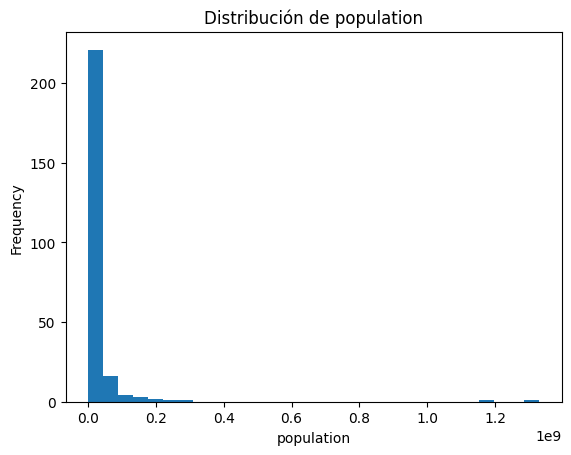

In [12]:
# Histograma de población
df["population"].plot(kind="hist", bins=30)
plt.title("Distribución de population")
plt.xlabel("population")
plt.show()


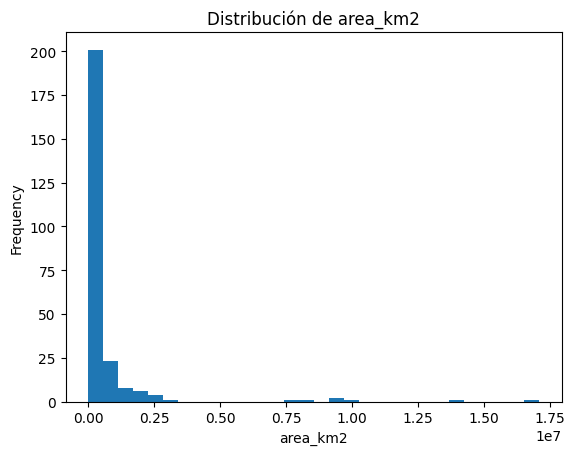

In [13]:
# Histograma de área
df["area_km2"].plot(kind="hist", bins=30)
plt.title("Distribución de area_km2")
plt.xlabel("area_km2")
plt.show()


### 2.5 Scatter plot (relación visual básica)

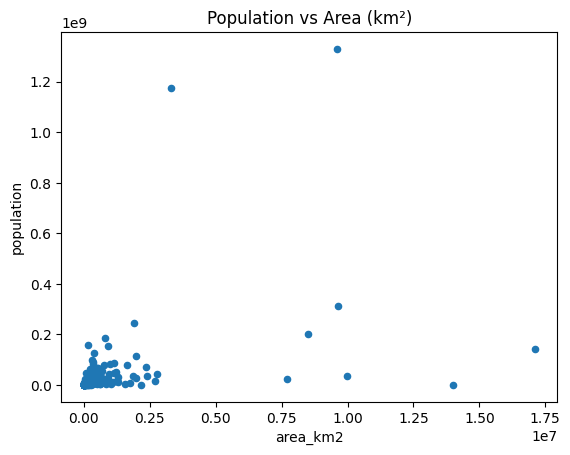

In [14]:
df.plot(kind="scatter", x="area_km2", y="population")
plt.title("Population vs Area (km²)")
plt.xlabel("area_km2")
plt.ylabel("population")
plt.show()


# Ejercicio 3 · Vacíos y nulos (20 min)

En datos reales es común encontrar:

- **nulos** (`NaN`): ausencia de dato
- **vacíos** (`""`): texto vacío (parece dato pero en realidad no aporta)
- valores “sucios”: espacios, 'N/A', 'unknown', etc.

Vamos a practicar **detección** y **tratamiento** con reglas simples.

### 3.1 Simular vacíos/nulos (solo para la práctica)

In [15]:
df_missing = df.copy()

# Simulamos algunos valores faltantes (solo para enseñar)
np.random.seed(42)
idx = np.random.choice(df_missing.index, size=10, replace=False)
df_missing.loc[idx[:5], "capital"] = ""        # vacíos
df_missing.loc[idx[5:], "area_km2"] = np.nan    # nulos

df_missing.loc[idx, ["country", "capital", "area_km2"]].head(10)


,country,capital,area_km2
142,Marshall Islands,,181.3
6,Armenia,,29800.0
97,Croatia,,56542.0
60,Dominican Republic,,48730.0
112,Jordan,,92300.0
181,Puerto Rico,San Juan,NaN
197,Singapore,Singapore,NaN
184,Palau,Melekeok,NaN
9,Argentina,Buenos Aires,NaN
104,India,New Delhi,NaN


### 3.2 Detectar nulos (`NaN`) y vacíos (`""`)

In [16]:
# Nulos por columna
df_missing.isna().sum()


,0
country,0
capital,0
population,0
area_km2,5


In [17]:
# Vacíos por columna (solo aplica a columnas tipo texto)
(df_missing["capital"] == "").sum()


np.int64(5)

### 3.3 Estandarizar vacíos → nulos

In [18]:
df_missing["capital"] = df_missing["capital"].replace("", np.nan)

# Ahora contamos nuevamente
df_missing.isna().sum()


,0
country,0
capital,5
population,0
area_km2,5


### 3.4 Tratar faltantes con reglas simples

In [19]:
# Regla simple 1: para correlación necesitamos population y area_km2
# Si falta alguna, eliminamos esas filas
df_numeric_clean = df_missing.dropna(subset=["population", "area_km2"]).copy()

print("Antes:", df_missing.shape)
print("Después:", df_numeric_clean.shape)


Antes: (250, 4)
Después: (245, 4)


In [20]:
# Regla simple 2: para capital, si falta, podemos imputar 'Unknown'
df_filled = df_numeric_clean.copy()
df_filled["capital"] = df_filled["capital"].fillna("Unknown")

df_filled.isna().sum()


,0
country,0
capital,0
population,0
area_km2,0


# Ejercicio 4 · Correlación Pearson (15 min)

La **correlación Pearson** mide la relación lineal entre dos variables numéricas.

- Va de **-1 a 1**
  - **1**: relación positiva perfecta
  - **0**: sin relación lineal
  - **-1**: relación negativa perfecta

⚠️ Importante:
- Correlación **no implica causalidad**.
- Pearson detecta relación **lineal** (no curvada).


### 4.1 Matriz de correlación (pandas)

In [29]:
corr = df_filled[["population", "area_km2"]].corr(method="pearson")
corr


,population,area_km2
population,1.00000,0.45796
area_km2,0.45796,1.00000


### 4.2 Interpretación rápida (texto)

In [30]:
coef = corr.loc["population", "area_km2"]
print(f"Correlación Pearson (population vs area_km2): {coef:.3f}")


Correlación Pearson (population vs area_km2): 0.458


### 4.3 Scatter plot para apoyar la interpretación

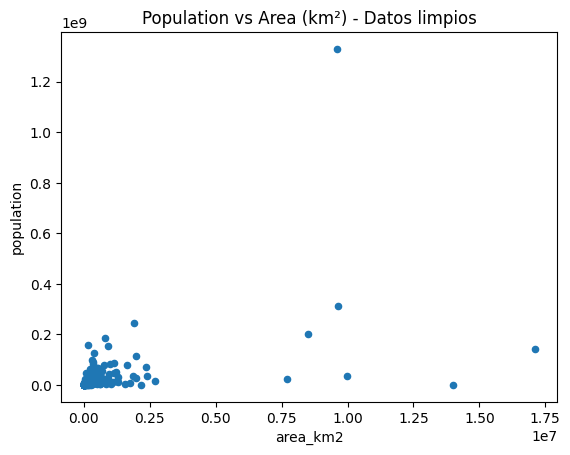

In [23]:
df_filled.plot(kind="scatter", x="area_km2", y="population")
plt.title("Population vs Area (km²) - Datos limpios")
plt.xlabel("area_km2")
plt.ylabel("population")
plt.show()


# Ejercicio 5 · Exportar resultados y publicar en GitHub (10 min)

En un mini‑proyecto de Data Analytics, lo mínimo publicable incluye:

- `notebook.ipynb`
- `data/` (CSV raw y limpio)
- `README.md` (qué hiciste y cómo reproducirlo)
- `.gitignore` (para no subir archivos innecesarios)

En este ejercicio exportaremos los datasets y dejaremos una guía paso a paso para GitHub.

### 5.1 Exportar datasets (raw y limpio)

In [24]:
import os

os.makedirs("data", exist_ok=True)

df.to_csv("data/countries_raw.csv", index=False)
df_filled.to_csv("data/countries_clean.csv", index=False)

print("Guardado:")
print("- data/countries_raw.csv")
print("- data/countries_clean.csv")


Guardado:
- data/countries_raw.csv
- data/countries_clean.csv


## README.md (plantilla sugerida)

In [25]:
readme = """# Web Scraping + EDA (Countries)

Mini-proyecto de Data Analytics:

1) Web scraping de un sitio estructurado (HTML) usando `requests` + `BeautifulSoup`
2) Construcción de dataset en `pandas`
3) EDA básico + manejo de nulos/vacíos
4) Correlación Pearson entre `population` y `area_km2`

## Fuente

- https://www.scrapethissite.com/pages/simple/

## Estructura

- `notebook.ipynb`
- `data/countries_raw.csv`
- `data/countries_clean.csv`

## Cómo reproducir

```bash
pip install requests beautifulsoup4 pandas matplotlib
```

Abrir el notebook y ejecutar de arriba hacia abajo.
"""

with open("README.md", "w", encoding="utf-8") as f:
    f.write(readme)

print("README.md creado")


README.md creado


## Paso a paso para subir a GitHub

### Opción A: GitHub Desktop (más fácil para principiantes)

1. Crea un repo en GitHub (ej: `web-scraping-eda-countries`).
2. Abre GitHub Desktop → *Add local repository*.
3. Selecciona la carpeta del proyecto.
4. Commit con mensaje: `Initial commit: scraping + EDA`.
5. Push → se publica en GitHub.

### Opción B: Git por consola (paso a paso)

En la carpeta del proyecto:

```bash
git init
git add .
git commit -m "Initial commit: scraping + EDA"
git branch -M main
git remote add origin <PEGA_AQUI_LA_URL_DE_TU_REPO>
git push -u origin main
```


# Cierre · Takeaways

Hoy practicaste un flujo completo de proyecto:

- **Scraping**: extraer datos desde HTML
- **Dataset**: convertir texto a números y estructurar columnas
- **EDA**: entender rangos, distribuciones y relaciones
- **Calidad**: detectar y tratar nulos/vacíos
- **Pearson**: correlación lineal básica (sin confundir con causalidad)
- **GitHub**: publicar tu trabajo con estructura mínima profesional

## Cierre

- Sube tu proyecto a tu GitHub, te servirá para tu portafolio!
- Practica extrayendo los datos de otra página web.
- No olvides subarte a los canales de **Co-Learning** y usar los recurso de ayuda en el canal de **DA_CONSULTA**.

**Siguiente paso sugerido:** agrega paginación (scrapear varias páginas) o añade más variables (por ejemplo región/continente desde otra fuente) y repite el EDA.
